In [113]:
#Import what technolgies you need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [114]:
# Load the Datasets
food_df = pd.read_csv("Louisville_Metro_KY_Inspection_Results_Food_Service_Establishments_1200720516040038198.csv")
gun_df = pd.read_csv("Gun_Violence_Data_3431704539549171373.csv")

In [115]:
#Show EDA of raw data
def data_overview(df: pd.DataFrame, name: str) -> None:
    print(f"{name}")
    print("Shape:", df.shape)
    print("\nColumn Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nFirst 5 Rows:")
    print(df.head())
    print("\nSummary Statistics:")
    print(df.describe(include='all'))

In [116]:
#using EDA function to see data
data_overview(food_df, "Food Inspection Data")
data_overview(gun_df, "Gun Violence Data")

Food Inspection Data
Shape: (6805, 21)

Column Types:
ScoreRecent                   int64
GradeRecent                  object
DateRecent                   object
Score2                        int64
Grade2                       object
Date2                        object
Score3                        int64
Grade3                       object
Date3                        object
permit_number                 int64
facility_type                 int64
facility_type_description    object
subtype                       int64
subtype_description          object
premise_name                 object
premise_address              object
premise_city                 object
premise_state                object
premise_zip                   int64
opening_date                 object
ObjectId                      int64
dtype: object

Missing Values:
ScoreRecent                     0
GradeRecent                  2930
DateRecent                   1356
Score2                          0
Grade2                 

In [117]:
#Clean Food Data
def clean_food_df(df: pd.DataFrame) -> pd.DataFrame:
    # Make a copy of Food Data
    df = df.copy()

    # Column names are lowercase and replace spaces with underscores
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Add a new column 'zip_code' from 'premise_zip' and format it as 5-digit strings
    df['zip_code'] = df['premise_zip'].astype(str).str.zfill(5)

    # Change 'daterecent' and 'opening_date' to proper datetime format
    df['daterecent'] = pd.to_datetime(df['daterecent'], errors='coerce')
    df['opening_date'] = pd.to_datetime(df['opening_date'], errors='coerce')

    # Remove missing values from specific columns
    df = df.dropna(subset=['scorerecent', 'graderecent', 'zip_code', 'daterecent'])

    # Replace blanks or missing with 'Unknown' and format text for 'facility_type'
    df['facility_type'] = df['facility_type'].replace('', np.nan)
    df['facility_type'] = df['facility_type'].fillna('Unknown')
    df['facility_type'] = df['facility_type'].astype(str).str.strip().str.title()

    # Fill missing city and state values with 'Unknown'
    df['premise_city'] = df['premise_city'].fillna('Unknown')
    df['premise_state'] = df['premise_state'].fillna('Unknown')

    # Fill missing facility names with 'Unnamed Facility'
    df['premise_name'] = df['premise_name'].fillna('Unnamed Facility')

    # Remove rows missing address information
    df = df.dropna(subset=['premise_address'])

    # Keep only inspections from 2020 onward
    df = df[df['daterecent'] >= pd.Timestamp('2020-01-01')]

    # Reset the index and return the cleaned DataFrame
    return df.reset_index(drop=True)

In [118]:
#Clean Gun Data
def clean_gun_df(df: pd.DataFrame) -> pd.DataFrame:
    # Make a copy of Gun Data
    df = df.copy()

    # Column names are lowercase and replace spaces with underscores
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    # Format ZIP codes as 5-digit strings
    df['zip_code'] = df['zip_code'].astype(str).str.zfill(5)

    # Convert the 'datetime' column to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

    # Remove missing values from specific columns
    df = df.dropna(subset=['zip_code', 'datetime', 'latitude', 'longitude', 'crime_type'])

    # Fill missing or blank values with 'Unknown'
    for col in ['sex', 'race', 'age_group']:
        df[col] = df[col].replace('', np.nan)            
        df[col] = df[col].fillna('Unknown')              
        df[col] = df[col].astype(str).str.strip().str.title()  
    # Fill missing neighborhood names with 'Unknown'
    df['neighborhood'] = df['neighborhood'].fillna('Unknown')

    # Fill missing cause descriptions with 'Unknown'
    df['cause'] = df['cause'].fillna('Unknown')

    # Keep only rows with incidents from 2020 onward
    df = df[df['datetime'] >= pd.Timestamp('2020-01-01')]

    # Create a new column for the hour of the day (0–23) from the datetime
    df['hour_of_day'] = df['datetime'].dt.hour

    # Reset the index and return the cleaned DataFrame
    return df.reset_index(drop=True)

In [119]:
#Storing clean data in new variable names
food_clean = clean_food_df(food_df)
gun_clean = clean_gun_df(gun_df)

In [120]:
#Using EDA function to look at the clean data
data_overview(food_clean, "Food Inspection Data")
data_overview(gun_clean, "Gun Violence Data")

Food Inspection Data
Shape: (3646, 22)

Column Types:
scorerecent                           int64
graderecent                          object
daterecent                   datetime64[ns]
score2                                int64
grade2                               object
date2                                object
score3                                int64
grade3                               object
date3                                object
permit_number                         int64
facility_type                        object
facility_type_description            object
subtype                               int64
subtype_description                  object
premise_name                         object
premise_address                      object
premise_city                         object
premise_state                        object
premise_zip                           int64
opening_date                 datetime64[ns]
objectid                              int64
zip_code              

In [121]:
#SQLite
#Connecting to Database
conn = sqlite3.connect("louisville_data.db")
food_clean.to_sql("food_inspections", conn, if_exists="replace", index=False)
gun_clean.to_sql("gun_violence", conn, if_exists="replace", index=False)

#Query and Join data
query = """
SELECT gv.zip_code,
       strftime('%Y-%m', gv.datetime) AS incident_month,
       COUNT(*) AS monthly_crimes,
       AVG(fi.scorerecent) AS avg_score,
       AVG(fi.graderecent) AS avg_grade,
       AVG(fi.scorerecent) / (COUNT(*) + 1.0) AS safety_score
FROM gun_violence gv
JOIN food_inspections fi
ON gv.zip_code = fi.zip_code
   AND strftime('%Y-%m', gv.datetime) = strftime('%Y-%m', fi.daterecent)
GROUP BY gv.zip_code, incident_month
ORDER BY monthly_crimes DESC
"""

#Store joined data
joined_data = pd.read_sql_query(query, conn)

In [122]:
#Check to see if Data sets have joined from zip_code
print(joined_data.shape)

(144, 6)


In [123]:
#Check first 5 columns
joined_data.head()

,zip_code,incident_month,monthly_crimes,avg_score,avg_grade,safety_score
0,40211,2025-01,5687,96.363636,0.0,0.016942
1,40203,2025-01,3680,97.875000,0.0,0.026589
2,40212,2025-01,2233,97.000000,0.0,0.043420
3,40211,2025-02,2057,98.176471,0.0,0.047705
4,40211,2024-12,1800,96.000000,0.0,0.053304


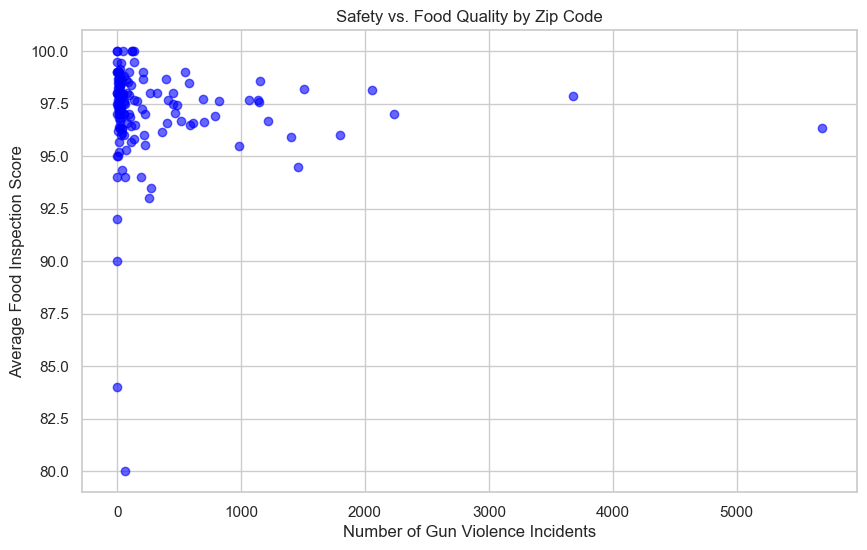

In [124]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(joined_data['monthly_crimes'], joined_data['avg_score'], alpha=0.6, color='blue')

# Add labels and title
plt.xlabel('Number of Gun Violence Incidents')
plt.ylabel('Average Food Inspection Score')
plt.title('Safety vs. Food Quality by Zip Code')
plt.grid(True)

# Show the plot
plt.show()

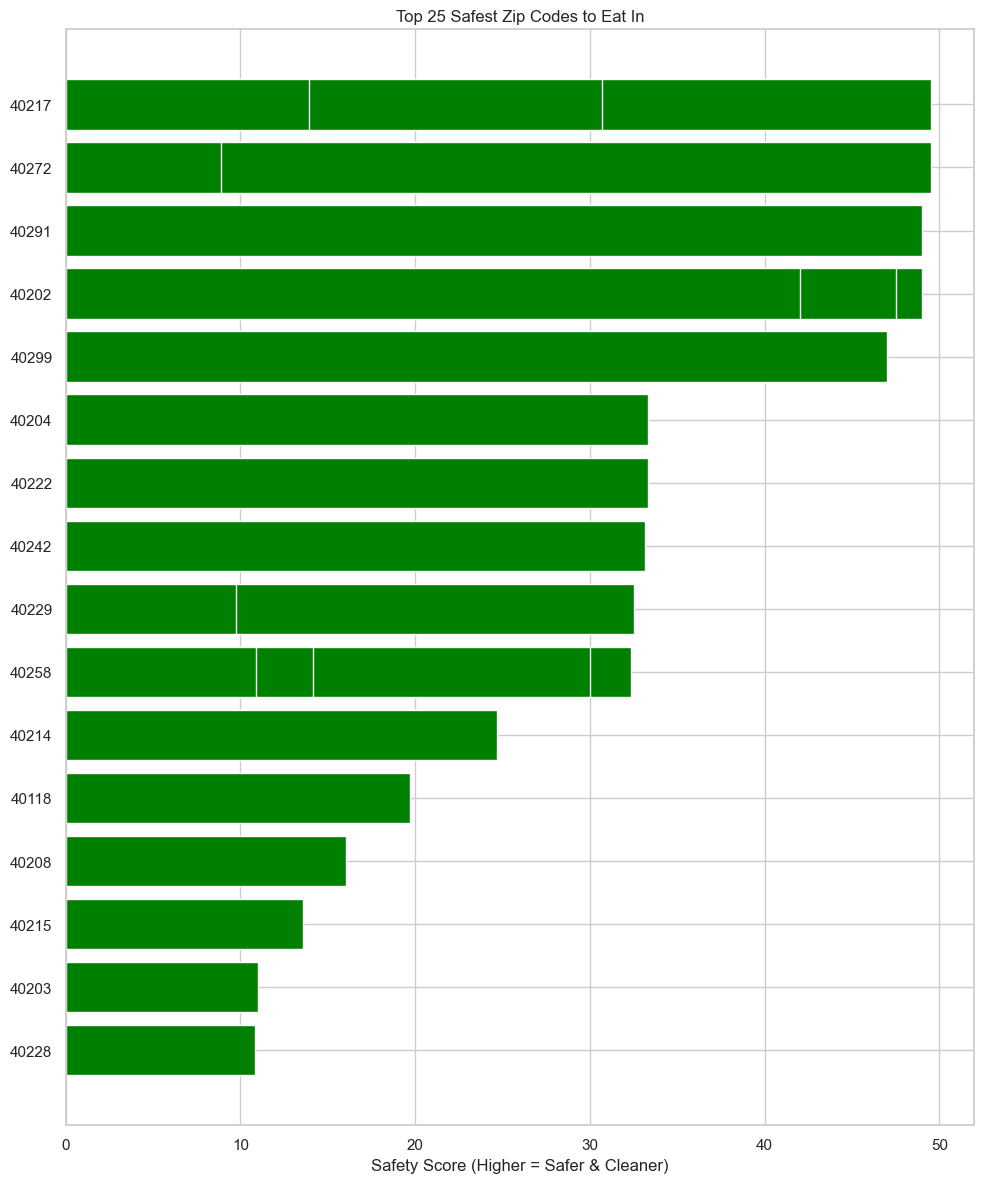

In [130]:
# Sort and select top 25 by safety score
top25 = joined_data.sort_values(by='safety_score', ascending=False).head(25)

# Create the bar chart
plt.figure(figsize=(10, 12))
bars = plt.barh(top25['zip_code'], top25['safety_score'], color='green')

# Add labels and title
plt.xlabel('Safety Score (Higher = Safer & Cleaner)')
plt.title('Top 25 Safest Zip Codes to Eat In')
plt.gca().invert_yaxis()



plt.tight_layout()
plt.show()

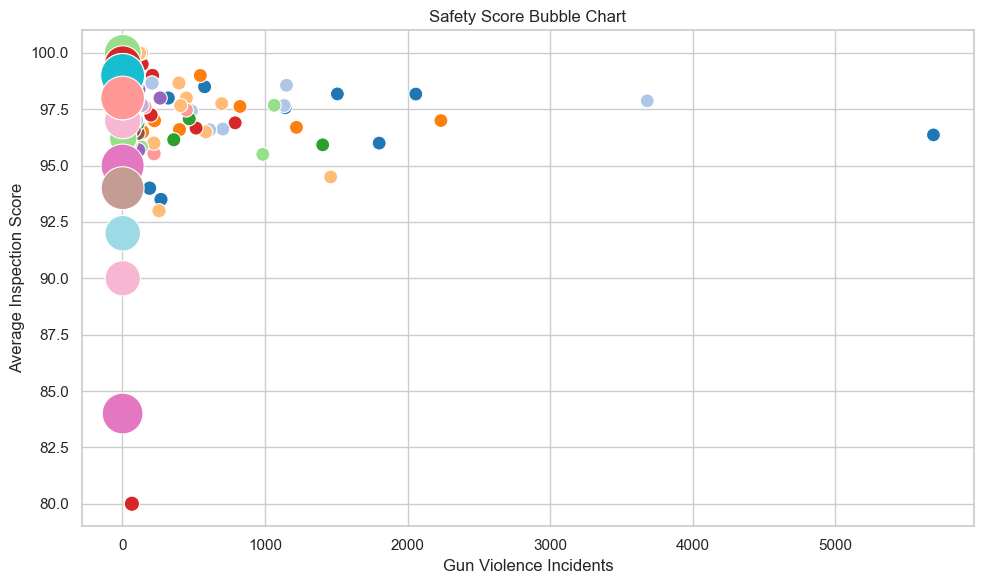

In [132]:
# Bubble chart setup
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='monthly_crimes',
    y='avg_score',
    size='safety_score',
    hue='zip_code',
    data=joined_data,
    sizes=(100, 1000),
    palette='tab20',
    legend=False
)

# Chart labels and display
plt.title('Safety Score Bubble Chart')
plt.xlabel('Gun Violence Incidents')
plt.ylabel('Average Inspection Score')
plt.tight_layout()

#Show the plot
plt.show()

In [127]:
joined_data.to_csv("joined_data.csv", index=False)